In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import train_test_split as surprise_tts, cross_validate, GridSearchCV
from sklearn.model_selection import train_test_split as sklearn_tts
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, confusion_matrix, root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor, plot_tree
import shap

# load the data into different DataFrames
ratings_df = pd.read_csv("ratings.csv")
movies_df = pd.read_csv("movies.csv")

print(ratings_df.head())
print(movies_df.head())

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


/home/gabrielorbe/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocessing

In [3]:
# merge ratings_df and movies_df
df = pd.merge(ratings_df, movies_df, on='movieId')

# convert timestamp column in df to YYYY-MM-DD HH:MM:SS and rename it
df["timestamp"] = pd.to_datetime(df["timestamp"], unit='s')
# df["timestamp"] = df["timestamp"].dt.strftime("%m-%d-%Y")
df.rename(columns={"timestamp": "date"}, inplace=True)

# check for missing values
missingValues = df.isna().sum()
# print(missingValues) # output proves there are no missing values in any column

# use one-hot encoding for genres
genreDummies = df["genres"].str.get_dummies('|')
df = pd.concat([df, genreDummies], axis=1)

# drop insignificant columns
dropColumns = ["genres", "(no genres listed)"]
df = df.drop(dropColumns, axis=1)

print(df)

        userId  movieId  rating                date  \
0            1        1     4.0 2000-07-30 18:45:03   
1            1        3     4.0 2000-07-30 18:20:47   
2            1        6     4.0 2000-07-30 18:37:04   
3            1       47     5.0 2000-07-30 19:03:35   
4            1       50     5.0 2000-07-30 18:48:51   
...        ...      ...     ...                 ...   
100831     610   166534     4.0 2017-05-03 21:53:22   
100832     610   168248     5.0 2017-05-03 22:21:31   
100833     610   168250     5.0 2017-05-08 19:50:47   
100834     610   168252     5.0 2017-05-03 21:19:12   
100835     610   170875     3.0 2017-05-03 21:20:15   

                                 title  Action  Adventure  Animation  \
0                     Toy Story (1995)       0          1          1   
1              Grumpier Old Men (1995)       0          0          0   
2                          Heat (1995)       1          0          0   
3          Seven (a.k.a. Se7en) (1995)       0     

## Exploratory Data Analysis

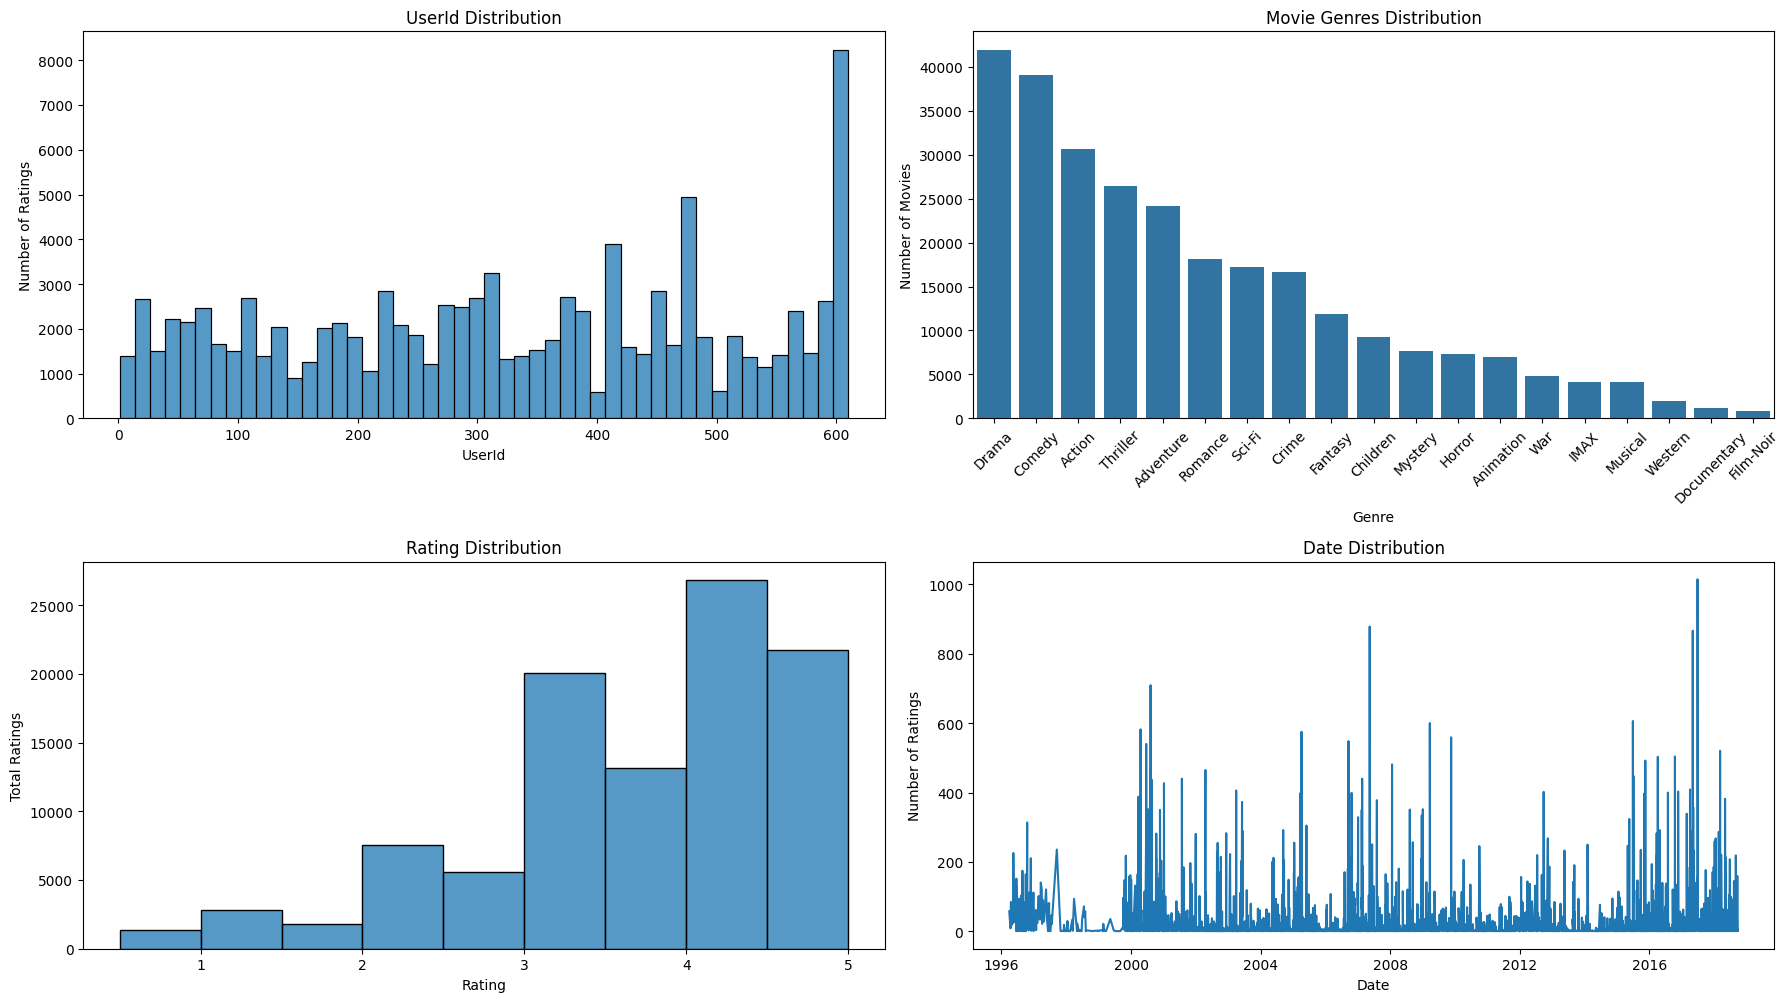

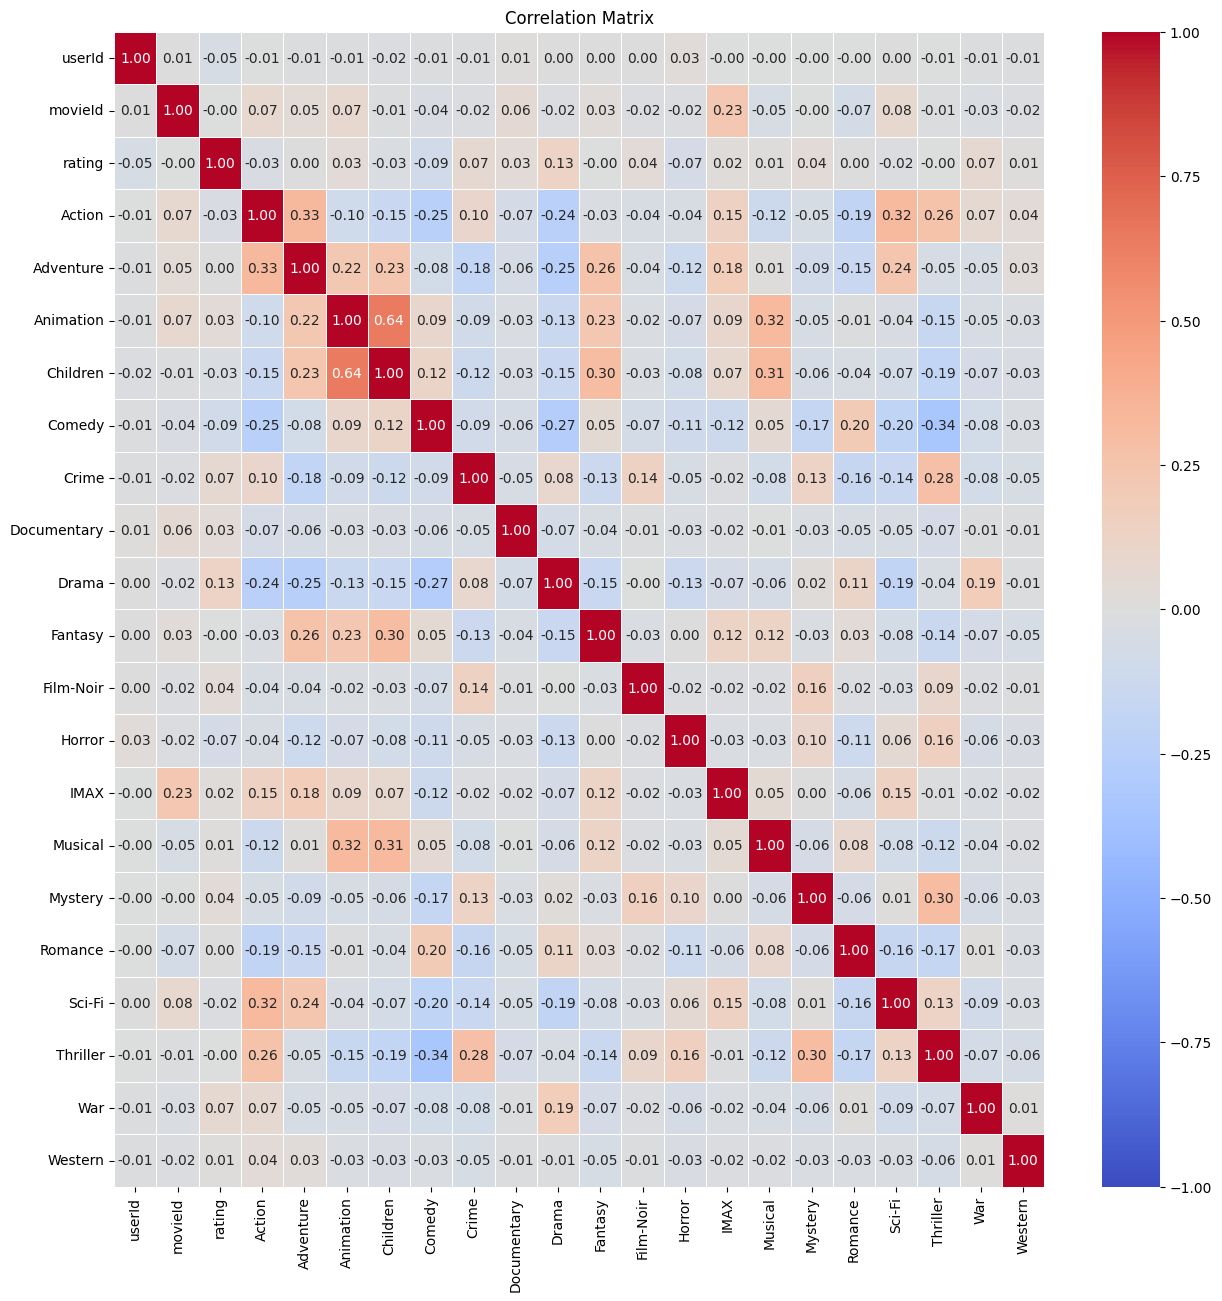

In [4]:
# distribution plots of each relevant feature (userId, genre, rating, date)
plt.figure(figsize=(18, 15))

# userId
plt.subplot(3, 2, 1)
sns.histplot(data=df, x="userId")
plt.title("UserId Distribution")
plt.xlabel("UserId")
plt.ylabel("Number of Ratings")
plt.tight_layout()

# genre
plt.subplot(3, 2, 2)
genres = df.columns[5:]
genres_df = df[genres].sum().sort_values(ascending=False).reset_index()
genres_df.columns = ["genre", "count"]
sns.barplot(data=genres_df, x="genre", y="count")
plt.title("Movie Genres Distribution")
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.xticks(rotation=45)
plt.tight_layout()

# rating
plt.subplot(3, 2, 3)
ratingBins = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
sns.histplot(data=df, x="rating", bins=ratingBins)
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Total Ratings")
plt.tight_layout()

# date
plt.subplot(3, 2, 4)
df["day"] = df["date"].dt.date
dayCount_df = df.groupby("day").size().reset_index(name="count")
df = df.drop(columns="day")
sns.lineplot(data=dayCount_df, x="day", y="count")
plt.title("Date Distribution")
plt.xlabel("Date")
plt.ylabel("Number of Ratings")
plt.tight_layout()

# correlation matrix
plt.figure(figsize=(15, 15))
plt.subplot(1, 1, 1)
corr_df = df.iloc[:, list(range(0, 3)) + list(range(5, 24))]
correlationMatrix = corr_df.corr()
sns.heatmap(correlationMatrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Correlation Matrix")

plt.show()

## Class Imbalance Problem

In [ ]:
# check distribution of target variable
print("Original target distribution:\n")
print(df['rating'].value_counts())

# load data
X = df.drop(['rating', 'title', 'date'], axis=1)
y = df["rating"]

# map movie ratings to categorical labels (1 for 0.5, 2 for 1.0, ..., 10 for 5.0)
ratingMapping = {val: idx for idx, val in enumerate(np.arange(0.5, 5.5, 0.5), 1)}
ratingInverseMapping = {value: key for key, value in ratingMapping.items()}
y_categorical = y.map(ratingMapping)

# split data
X_train, X_test, y_train_categorical, y_test = sklearn_tts(X, y_categorical, test_size=0.2, random_state=11)

# use SMOTE technique
sm = SMOTE(random_state=11)
X_resampled, y_resampled_categorical = sm.fit_resample(X_train, y_train_categorical)

# map back to original ratings
y_resampled = y_resampled_categorical.map(ratingInverseMapping)

# ensure ratings appear in given order
ordered_ratings = sorted(np.arange(0.5, 5.5, 0.5), reverse=True)
y_resampled = pd.Series(y_resampled).apply(lambda x: round(x, 1))

# verify resampled distribution
print("Resampled target distribution:\n", pd.Series(y_resampled).value_counts().sort_index(ascending=False))

# train a Random Forest regression model
resampled_rf_model = RandomForestRegressor(random_state=11)
resampled_rf_model.fit(X_resampled, y_resampled)

# evaluate the model
y_pred = resampled_rf_model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print(f"RMSE on Test Set: {rmse}")

rating
4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: count, dtype: int64
Resampled target distribution:
 rating
5.0    21506
4.5    21506
4.0    21506
3.5    21506
3.0    21506
2.5    21506
2.0    21506
1.5    21506
1.0    21506
0.5    21506
Name: count, dtype: int64


## Machine Learning Models

SVD Model:

In [ ]:
# load & split data to Surprise format
reader = Reader(rating_scale=(0.5, 5.0))
surpriseData = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
trainset, testset = surprise_tts(surpriseData, test_size=0.2, random_state=11)

# create SVD model
svd_model = SVD()
cvResults = cross_validate(svd_model, surpriseData, measures=["RMSE", "MAE"], cv=5)

# test SVD model
print("Average RMSE:", cvResults["test_rmse"].mean())
print("Average MAE:", cvResults["test_mae"].mean())

# dynamic grid search function
def dynamicGridSearch(data, baseParameters, param_grid, measure="rmse", threshold=0.001, max_iter=5):
    bestScore = float("inf")
    bestParameters = baseParameters
    grid = param_grid

    for i in range(max_iter):
        print(f"Iteration {i+1} with grid: {grid}")

        # perform GridSearchCV
        gs = GridSearchCV(SVD, param_grid, measures=[measure], cv=5)
        gs.fit(data)

        # check if best score is substantial, then update it and parameters
        if gs.best_score[measure] < bestScore - threshold:
            bestScore = gs.best_score[measure]
            bestParameters = gs.best_params[measure]

            print(f"Improved {measure}: {bestScore}, Best Parameters: {bestParameters}")

            # update parameter grid
            grid = {
                "n_epochs": [max(5, bestParameters["n_epochs"] - 5), bestParameters["n_epochs"], bestParameters["n_epochs"] + 5],
                "lr_all": np.round(np.linspace(max(0.0001, bestParameters["lr_all"] / 2), bestParameters["lr_all"] * 2, 3), 6).tolist(),
                "reg_all": np.round(np.linspace(max(0.0001, bestParameters["reg_all"] / 2), bestParameters["reg_all"] * 2, 3), 6).tolist()
            }
        else:
            print("No significant improvement.")
            break

    return bestScore, bestParameters

# initial parameter grid
param_grid = {
    "n_epochs": [5, 10, 15],
    "lr_all": [0.002, 0.005, 0.01],
    "reg_all": [0.2, 0.4, 0.6]
}

# base parameters
base_params = {}

# perform adaptive grid search
bestRSME, bestParameters = dynamicGridSearch(surpriseData, base_params, param_grid, measure="rmse", threshold=0.001)
print("Best RMSE:", bestRSME)
print("Best Parameters:", bestParameters)

Average RMSE: 0.8734832022239629
Average MAE: 0.6715557437022449
Iteration 1 with grid: {'n_epochs': [5, 10, 15], 'lr_all': [0.002, 0.005, 0.01], 'reg_all': [0.2, 0.4, 0.6]}
Improved rmse: 0.8719442148319843, Best Parameters: {'n_epochs': 15, 'lr_all': 0.01, 'reg_all': 0.2}
Iteration 2 with grid: {'n_epochs': [10, 15, 20], 'lr_all': [0.005, 0.0125, 0.02], 'reg_all': [0.1, 0.25, 0.4]}
No significant improvement.
Best RMSE: 0.8719442148319843
Best Parameters: {'n_epochs': 15, 'lr_all': 0.01, 'reg_all': 0.2}


Random Forest Model:

Random Forest R2 Score: 0.15849769932263258
Random Forest RMSE: 0.9577764670625324


<Figure size 1200x400 with 0 Axes>

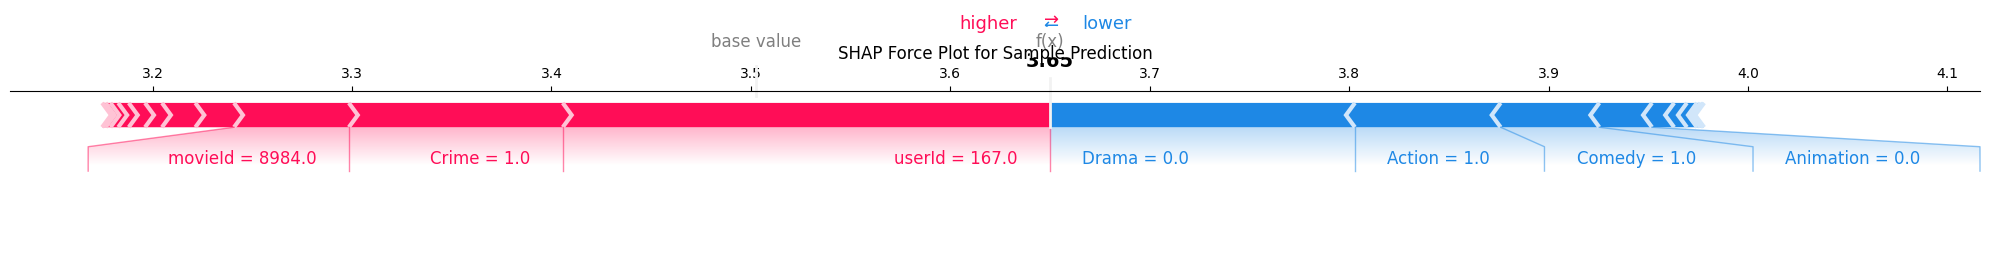

In [ ]:
# split data
X_train, X_test, y_train, y_test = sklearn_tts(X, y, test_size=0.2, random_state=11)

# Random Forest model for feature importance and SHAP values
rf_model = RandomForestRegressor(n_estimators=100, random_state=11)
rf_model.fit(X_train, y_train)

# make predictions
rf_predictions = rf_model.predict(X_test)

# calculate R2 score and RMSE
r2 = r2_score(y_test, rf_predictions)
rmse = root_mean_squared_error(y_test, rf_predictions)
print(f"Random Forest R2 Score: {r2}")
print(f"Random Forest RMSE: {rmse}")

# sample a smaller subset of test data for SHAP analysis
sample_size = 10
random_indices = np.random.choice(len(X_test), min(sample_size, len(X_test)), replace=False)
X_test_sample = X_test.iloc[random_indices]

# calculate SHAP values on the sampled dataset
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_sample)

# for individual prediction analysis, use first sample
sample_idx = 0
plt.figure(figsize=(12, 4))
shap.force_plot(explainer.expected_value, 
                shap_values[sample_idx],
                X_test_sample.iloc[sample_idx],
                matplotlib=True,
                show=False)
plt.title('SHAP Force Plot for Sample Prediction')
plt.tight_layout()
plt.show()

Confusion Matrix:

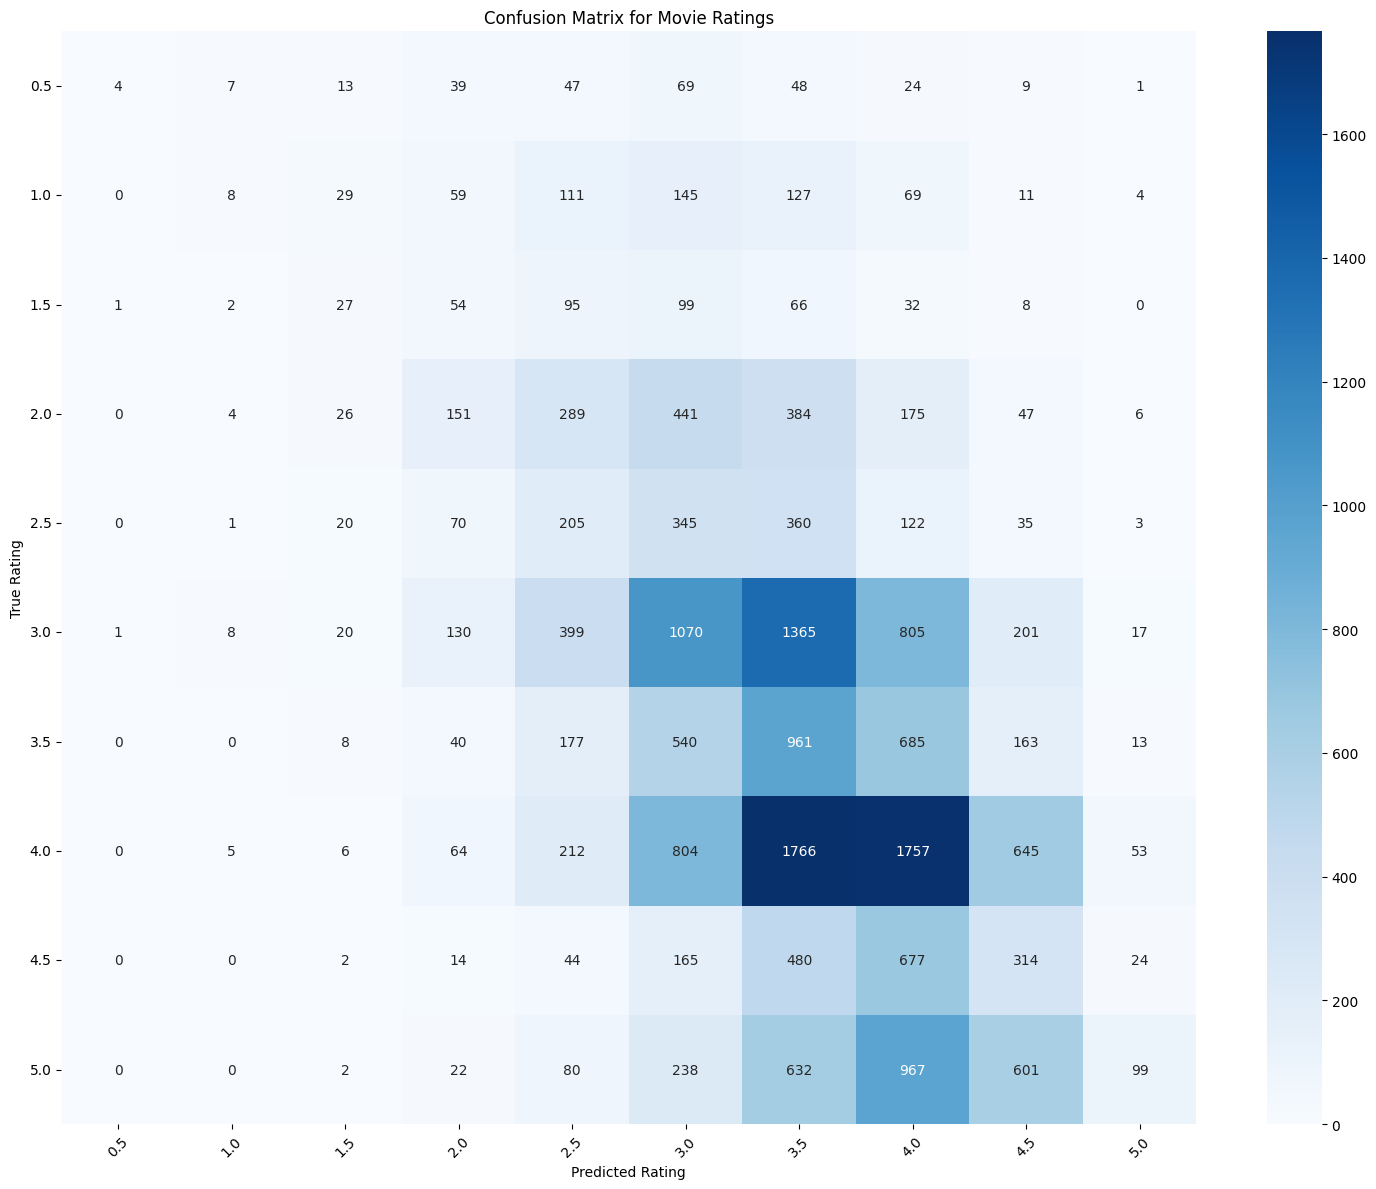

In [ ]:
# convert predictions to nearest valid rating value
validRatings = np.arange(0.5, 5.5, 0.5)
rf_predictions_rounded = np.array([validRatings[np.abs(validRatings - pred).argmin()] for pred in rf_predictions])

# convert ratings to categorical labels (1-10) for confusion matrix
y_test_cat = np.array([int((rating * 2) - 1) for rating in y_test])
rf_predictions_cat = np.array([int((rating * 2) - 1) for rating in rf_predictions_rounded])

# create and plot confusion matrix
cm = confusion_matrix(y_test_cat, rf_predictions_cat)
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# create rating labels
rating_labels = [f'{r:.1f}' for r in np.arange(0.5, 5.5, 0.5)]

plt.title('Confusion Matrix for Movie Ratings')
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.xticks(np.arange(len(rating_labels)) + 0.5, rating_labels, rotation=45)
plt.yticks(np.arange(len(rating_labels)) + 0.5, rating_labels, rotation=0)
plt.tight_layout()
plt.show()

## Model Interpretation

Decision Tree:

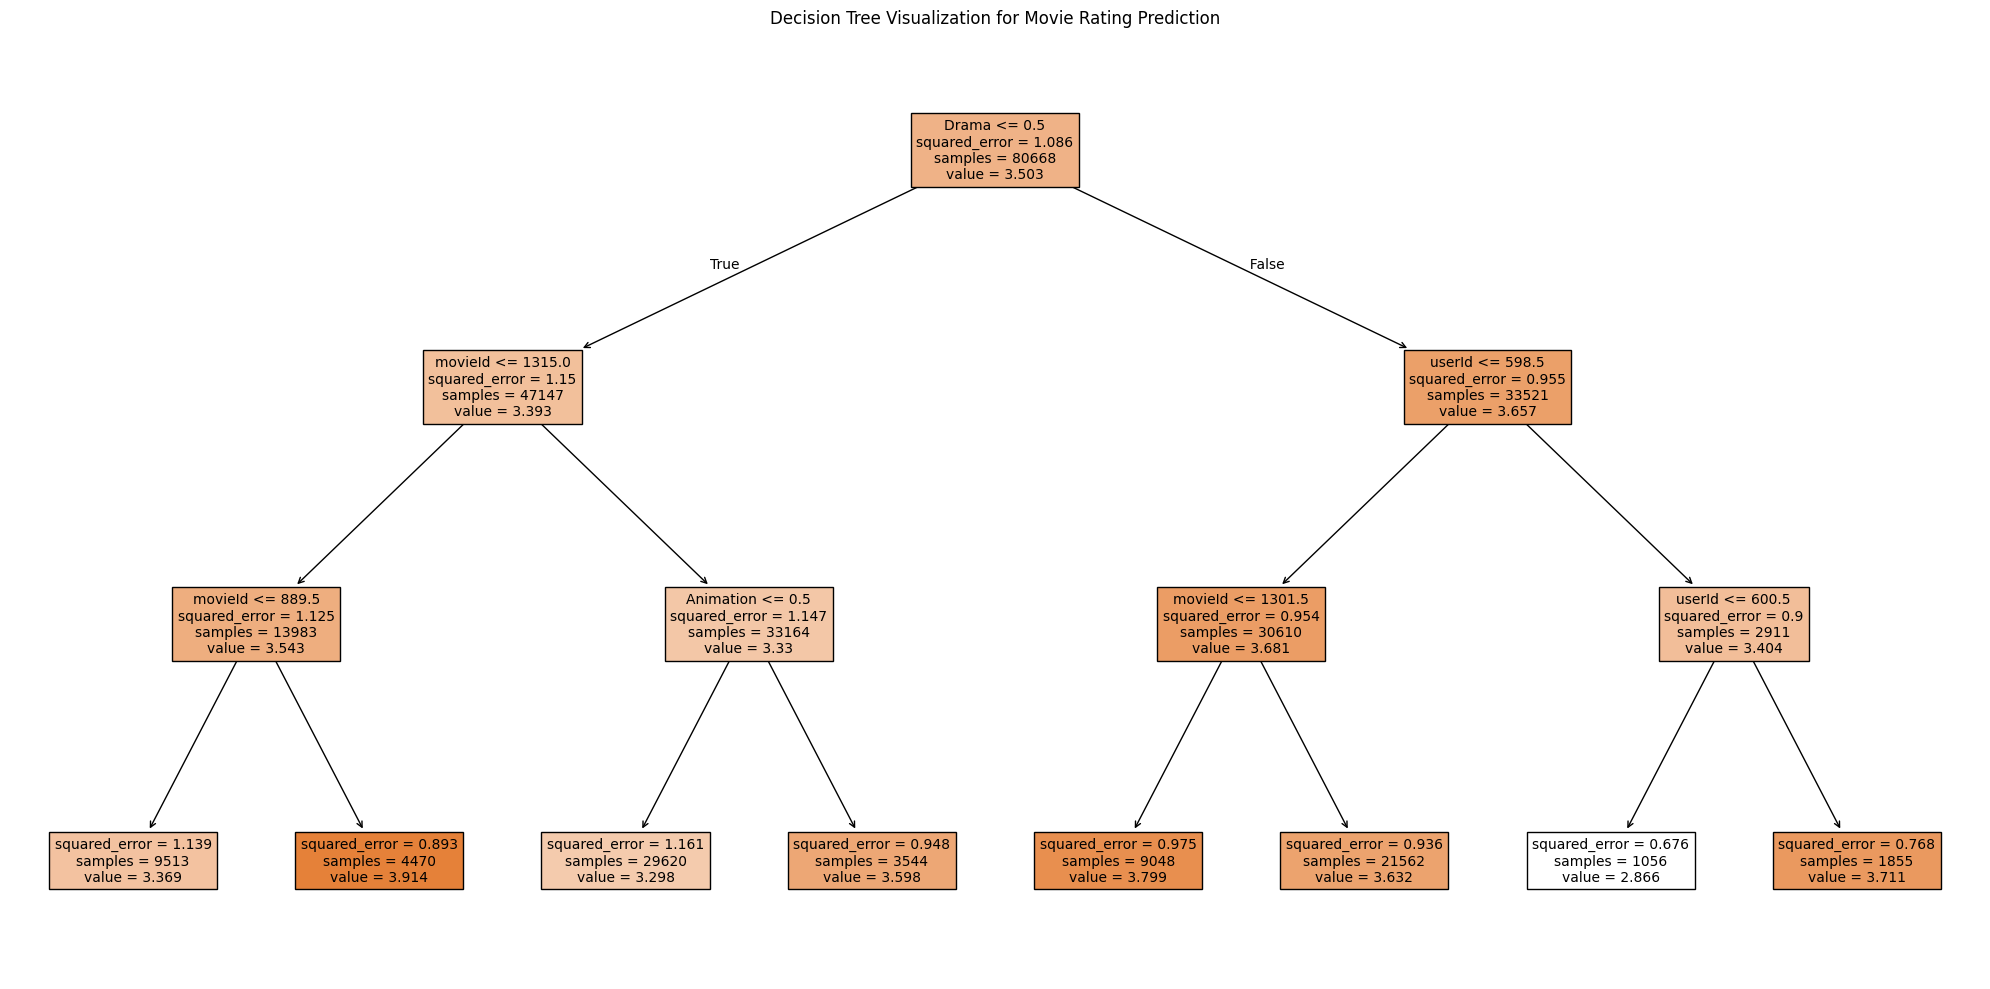

Decision Tree RMSE: 1.022010502672151


In [ ]:
# train decision tree
dt_model = DecisionTreeRegressor(max_depth=3, random_state=11)
dt_model.fit(X_train, y_train)

# display it
plt.figure(figsize=(20,10))
plot_tree(dt_model, feature_names=X.columns, filled=True, fontsize=10)
plt.title("Decision Tree Visualization for Movie Rating Prediction")
plt.tight_layout()
plt.show()

# calculate performance
dt_predictions = dt_model.predict(X_test)
dt_rmse = root_mean_squared_error(y_test, dt_predictions)
print(f"Decision Tree RMSE: {dt_rmse}")

## Results

We're going to use the user w/ userId = 1 as an example

In [ ]:
givenUserId = 1

# create best SVD model using parameters gathered from dynamic grid search function
bestSVD_model = SVD(n_epochs=bestParameters['n_epochs'],
               lr_all=bestParameters['lr_all'],
               reg_all=bestParameters['reg_all'])
bestSVD_model.fit(trainset)

# get movies to predict
userRatedMovies = set(df[df['userId'] == givenUserId]['movieId'])
allMovies = set(df['movieId'].unique())
moviesToPredict = list(allMovies - userRatedMovies)

# make predictions for all unwatched movies
predictions = []
for movie_id in moviesToPredict:
    pred = bestSVD_model.predict(givenUserId, movie_id)
    predictions.append((movie_id, pred.est))
# print(f"Predictions: {predictions}")

# sort predictions and get top 5
top5Predictions = sorted(predictions, key=lambda x: x[1], reverse=True)[:5]

# show movie recommendations
print(f"User {givenUserId}'s Top 5 Movie Recommendations:")
for givenMovieId, predictedRating in top5Predictions:
    movieInfo = df[df['movieId'] == givenMovieId].iloc[0]
    print(f"Movie: {movieInfo['title']}, Predicted Rating: {predictedRating:.2f} / 5.00")

# show this user's actual top 5 movies
print(f"\nUser {givenUserId}'s Top 5 Previously Rated Movies:")
userRatings = df[df['userId'] == givenUserId]
topRated = userRatings.nlargest(5, 'rating')
for _, row in topRated.iterrows():
    print(f"Movie: {row['title']}, Rating: {row['rating']} / 5.00")

User 1's Top 5 Movie Recommendations:
Movie: Hustler, The (1961), Predicted Rating: 4.99 / 5.00
Movie: Guess Who's Coming to Dinner (1967), Predicted Rating: 4.96 / 5.00
Movie: Little Big Man (1970), Predicted Rating: 4.93 / 5.00
Movie: Streetcar Named Desire, A (1951), Predicted Rating: 4.92 / 5.00
Movie: Bridge on the River Kwai, The (1957), Predicted Rating: 4.92 / 5.00

User 1's Top 5 Previously Rated Movies:
Movie: Seven (a.k.a. Se7en) (1995), Rating: 5.0 / 5.00
Movie: Usual Suspects, The (1995), Rating: 5.0 / 5.00
Movie: Bottle Rocket (1996), Rating: 5.0 / 5.00
Movie: Rob Roy (1995), Rating: 5.0 / 5.00
Movie: Canadian Bacon (1995), Rating: 5.0 / 5.00
